In [20]:
import sys
!{sys.executable} -m pip install textblob


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.8/636.8 kB 7.1 MB/s eta 0:00:0000:0100:01


In [3]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import config
import psycopg2
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import re as re
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.tokenize.api import TokenizerI
from sklearn import model_selection


In [4]:
hostname = config.hostname
dbname = config.dbname
uname = config.uname
pwd = config.pwd

engine = create_engine("postgresql://{user}:{pw}@{host}/{db}".format(host=hostname, db=dbname, user=uname, pw=pwd), pool_size=20, max_overflow=0)

In [5]:
tweets = pd.read_sql("SELECT * FROM tweets", con=engine)
tweets.shape

(9141, 9)

In [6]:
tweets.tail()

,tweet_id,author_id,tweet_text,like_count,quote_count,reply_count,retweet_count,place,date
9136,1565432205278527488,1429651538943881219,"RT @lvnareclps: SEPTEMBER: change of seasons, ...",0,0,0,54,None,2022-09-01
9137,1565432203940884480,104966925,@SMTuffy Apparently only if you roll your own....,2,0,1,0,None,2022-09-01
9138,1565432201432416259,252803959,"RT @TerryJobe3: It's Thursday, college footbal...",0,0,0,1,None,2022-09-01
9139,1565432174978924545,1539702502832103425,@Joshua_T_G @michaeljknowles BUT do you prefer...,0,0,0,0,None,2022-09-01
9140,1565432166363930625,583250445,Pumpkin Spice Submission season begins.,0,0,0,0,None,2022-09-01


In [7]:
users = pd.read_sql("SELECT * FROM users", con=engine)
users.shape

(8559, 7)

In [8]:
users.describe()

,follower_count,following_count,tweet_count
count,8.559000e+03,8559.000000,8.559000e+03
mean,6.345239e+03,1082.758149,3.526796e+04
std,1.590315e+05,2884.980012,9.268272e+04
min,0.000000e+00,0.000000,1.000000e+00
25%,1.170000e+02,183.500000,2.759000e+03
50%,3.720000e+02,420.000000,1.098300e+04
75%,1.143500e+03,970.500000,3.423300e+04
max,1.401940e+07,101887.000000,3.979533e+06


In [9]:
users['acct_created'] = pd.to_datetime(users['acct_created'])

In [10]:
users.groupby(users.acct_created.dt.year).size()

acct_created
2006      3
2007     55
2008    210
2009    835
2010    469
2011    658
2012    670
2013    531
2014    531
2015    474
2016    437
2017    434
2018    489
2019    538
2020    701
2021    763
2022    761
dtype: int64

In [11]:
tweets['date'] = pd.to_datetime(tweets['date'])
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9141 entries, 0 to 9140
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   tweet_id       9141 non-null   object        
 1   author_id      9141 non-null   object        
 2   tweet_text     9141 non-null   object        
 3   like_count     9141 non-null   int64         
 4   quote_count    9141 non-null   int64         
 5   reply_count    9141 non-null   int64         
 6   retweet_count  9141 non-null   int64         
 7   place          2272 non-null   object        
 8   date           9141 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 642.9+ KB


In [12]:
twit_by_date_size = tweets.groupby('date').size()
twit_by_date_size.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 6 entries, 2022-08-27 to 2022-09-01
Series name: None
Non-Null Count  Dtype
--------------  -----
6 non-null      int64
dtypes: int64(1)
memory usage: 96.0 bytes


<AxesSubplot:xlabel='date'>

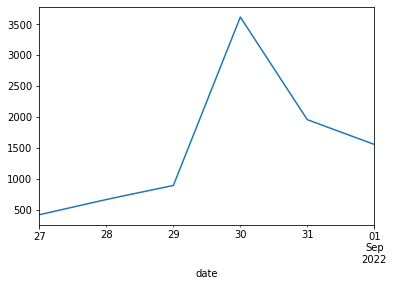

In [13]:
twit_by_date_size.plot()

In [14]:
testdf= tweets.groupby(['date'])['like_count', 'quote_count', 'reply_count', 'retweet_count',].sum()

/var/folders/rw/1rnjc7b90vd_mr3753j04_s40000gp/T/ipykernel_25214/4062091766.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  testdf= tweets.groupby(['date'])['like_count', 'quote_count', 'reply_count', 'retweet_count',].sum()


In [15]:
testdf.reset_index(inplace=True)

In [16]:
testdf.head()

,date,like_count,quote_count,reply_count,retweet_count
0,2022-08-27,386,6,64,18381
1,2022-08-28,544,15,124,27484
2,2022-08-29,595,33,162,92319
3,2022-08-30,726,19,199,3277508
4,2022-08-31,498,13,150,1856695


<AxesSubplot:xlabel='date'>

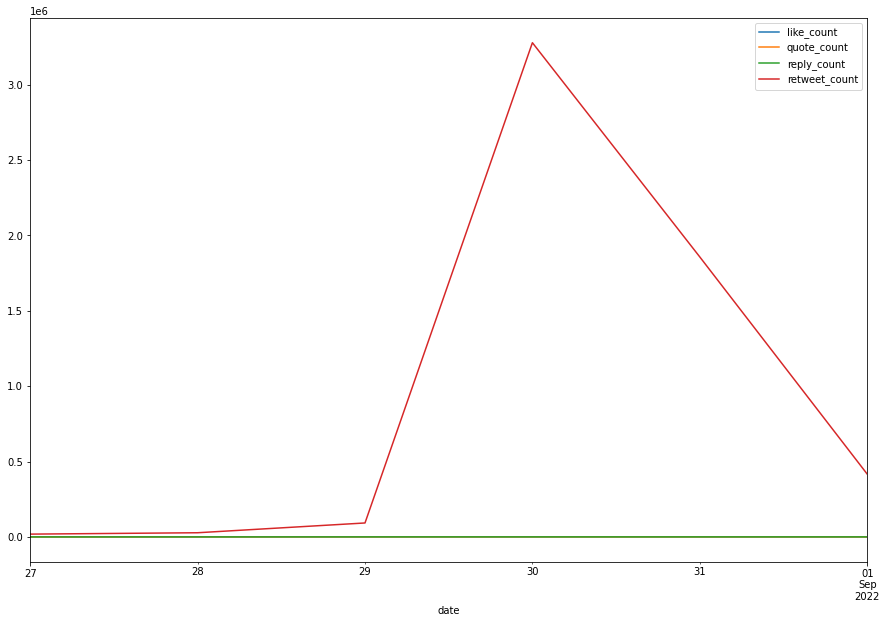

In [17]:
testdf.plot(kind='line', x='date', figsize=(15,10))

In [18]:
print("There are {} different users".format(users['username'].nunique()))

There are 8559 different users


In [19]:
mergedDF = pd.merge(tweets, users, how="left", left_on="author_id", right_on="user_id")

In [20]:
usertweets = mergedDF.groupby('username')

In [21]:
top_users = usertweets.count()['tweet_text'].sort_values(ascending = False)[:25]
top_users_dict = top_users.to_dict()
user_ordered_dict = sorted(top_users_dict.items(), key=lambda x:x[1])
user_ordered_dict = user_ordered_dict[::-1]

dict_values = []
dict_keys = []
for item in user_ordered_dict[0:25]:
    dict_keys.append(item[0])
    dict_values.append(item[1])

username
dunkindonuts       82
MormorJan          15
faremine           12
ACanvasaDay         8
AcornTops           7
JojoLuxray          5
matthew_leal        5
dogandwinelover     5
mytbrisgrowing      5
80suburbia          5
sarah052794         4
_AXIII_             4
TheBBWBombshell     4
DarthTonka1979      3
rumdrinker71        3
MintChipMusic       3
Ricky_Breeze        3
mcsweeneys          3
TheLeonardBast      3
Rafanotcreative     3
FlorenceCarmela     3
BNodoubts           3
shalewagg2          3
nahsam_             3
TheWizardsQuest     3
Name: tweet_text, dtype: int64


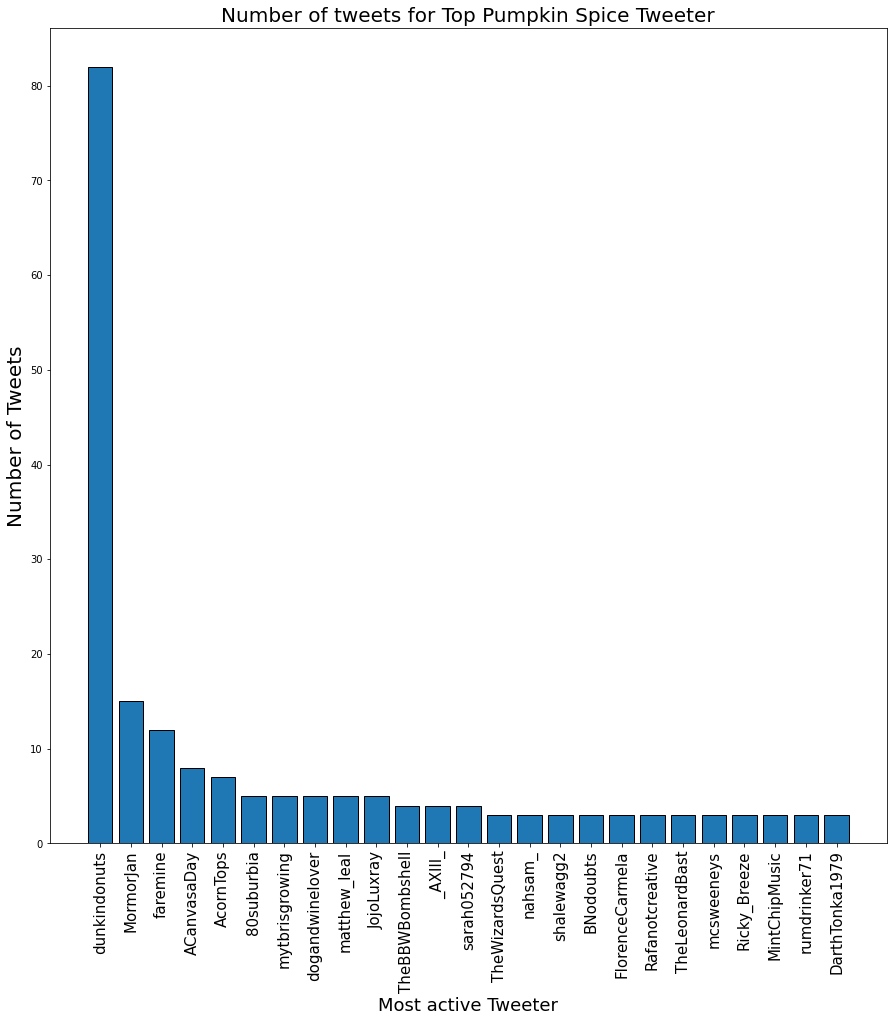

In [22]:
fig = plt.figure(figsize = (15,15))
index = np.arange(25)
plt.bar(index, dict_values, edgecolor = 'black', linewidth=1)
plt.xlabel('Most active Tweeter', fontsize = 18)
plt.ylabel('Number of Tweets', fontsize=20)
plt.xticks(index,dict_keys, fontsize=15, rotation=90)
plt.title('Number of tweets for Top Pumpkin Spice Tweeter', fontsize = 20)
plt.show()

In [23]:
tweets['RT'] = tweets['tweet_text'].str.startswith('RT')
#finding retweets

In [24]:
#See the percentage of tweets from the initial set that are retweets:
RT_tweets = tweets[tweets['RT'] == True]
print(f"The percentage of retweets is {round(len(RT_tweets)/len(tweets)*100)}% of all the tweets")

The percentage of retweets is 45% of all the tweets


In [25]:
tweets['Reply'] = tweets['tweet_text'].str.startswith('@')
tweets.head()

,tweet_id,author_id,tweet_text,like_count,quote_count,reply_count,retweet_count,place,date,RT,Reply
0,1563558331608100864,967075191842099200,Check out this item in my Etsy shop https://t....,0,0,0,0,,2022-08-27,False,False
1,1563558255502053376,1269673234552758276,i need to get a milk frother so i can make my ...,0,0,0,0,None,2022-08-27,False,False
2,1563558116423188480,94892479,Having my first pumpkin spice latte this morni...,0,0,0,0,None,2022-08-27,False,False
3,1563558033669509122,1096866679013982210,@brimorganbooks Yesss! We got pumpkin spice co...,0,0,0,0,None,2022-08-27,False,True
4,1563557995677569024,746878617397899264,Got my pumpkin spice iced coffee I’m ready to ...,0,0,0,0,None,2022-08-27,False,False


In [26]:
reply_tweets = tweets[tweets['Reply'] == True]
print(f"The percentage of tweet replies is {round(len(reply_tweets)/len(tweets)*100)}% of all the tweets")

The percentage of tweet replies is 15% of all the tweets


In [27]:
mention_tweets = tweets[(tweets['RT']==False) & (tweets['Reply'] == False) & (tweets['tweet_text'].str.contains('@'))]
print(f"The percentage of mentions is {round(len(mention_tweets)/len(tweets)*100)}% of all the tweets")

The percentage of mentions is 3% of all the tweets


In [28]:
plain_text_tweets = tweets[~tweets['tweet_text'].str.contains("@")  & ~tweets['tweet_text'].str.contains("RT")]
print(f"The percentage of retweets is {round(len(plain_text_tweets)/len(tweets)*100)}% of all the tweets")

The percentage of retweets is 38% of all the tweets


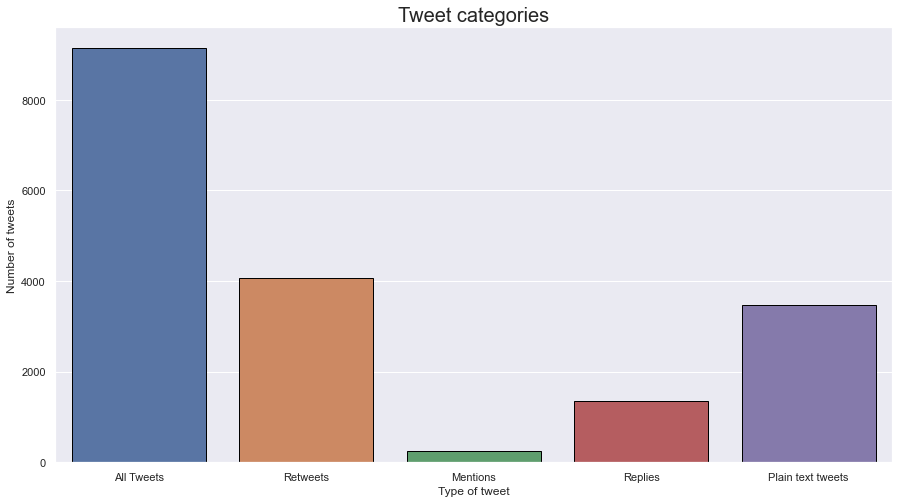

In [29]:
len_list = [ len(tweets), len(RT_tweets),len(mention_tweets), len(reply_tweets), len(plain_text_tweets)]
item_list = ['All Tweets','Retweets', 'Mentions', 'Replies', 'Plain text tweets']
plt.figure(figsize=(15,8))
sns.set(style="darkgrid")
plt.title('Tweet categories', fontsize = 20)
plt.xlabel('Type of tweet')
plt.ylabel('Number of tweets')
sns.barplot(x = item_list, y = len_list,  edgecolor = 'black', linewidth=1)

plt.show()

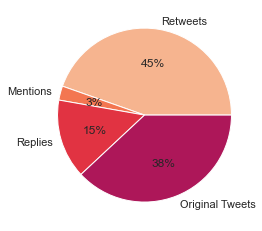

In [30]:
len_data = [len(RT_tweets)/len(tweets),len(mention_tweets)/len(tweets), len(reply_tweets)/len(tweets), len(plain_text_tweets)/len(tweets)]
item_data = ['Retweets', 'Mentions', 'Replies', 'Original Tweets']

# define Seaborn color palette to use
colors = sns.color_palette('rocket_r')[0:4]

#create pie chart
plt.pie(len_data, labels = item_data, colors = colors, autopct='%.0f%%')
plt.show()

In [31]:
#Going to see the most used hashtags.
hashtags = []
hashtag_pattern = re.compile(r"#[a-zA-Z]+")
hashtag_matches = list(tweets['tweet_text'].apply(hashtag_pattern.findall))

In [32]:
hashtag_dict = {}
for match in hashtag_matches:
    for singlematch in match:
        if singlematch not in hashtag_dict.keys():
            hashtag_dict[singlematch] = 1
        else:
            hashtag_dict[singlematch] = hashtag_dict[singlematch]+1

In [33]:
hashtag_ordered_list = sorted(hashtag_dict.items(), key=lambda x: x[1])
hashtag_ordered_list = hashtag_ordered_list[::-1]
#making list of the most used hashtags and their values

In [34]:
hashtag_ordered_values = []
hashtag_ordered_keys = []

for item in hashtag_ordered_list[0:20]:
    hashtag_ordered_keys.append(item[0])
    hashtag_ordered_values.append(item[1])
    
#separating hashtags and values into lists, picking top 20 hashtags to plot

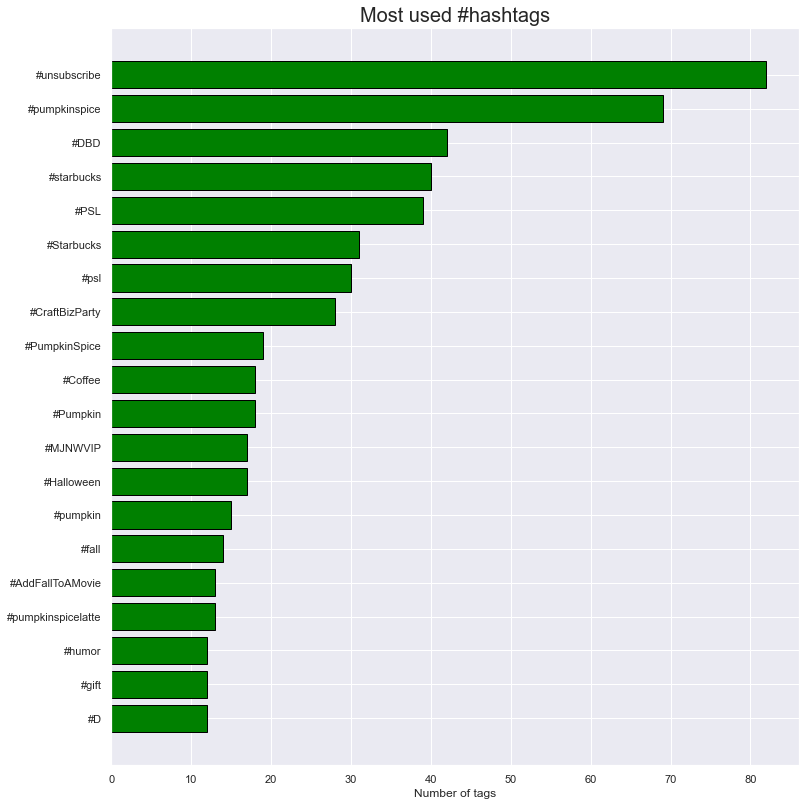

In [35]:
fig, ax = plt.subplots(figsize = (12,12))
y_pos = np.arange(len(hashtag_ordered_keys))
ax.barh(y_pos, list(hashtag_ordered_values)[::-1], align='center', color='green', edgecolor='black', linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(list(hashtag_ordered_keys)[::-1])
ax.set_xlabel("Number of tags")
ax.set_title("Most used #hashtags", fontsize = 20)
plt.tight_layout(pad=3)

plt.show()

#graph with most used hashtags

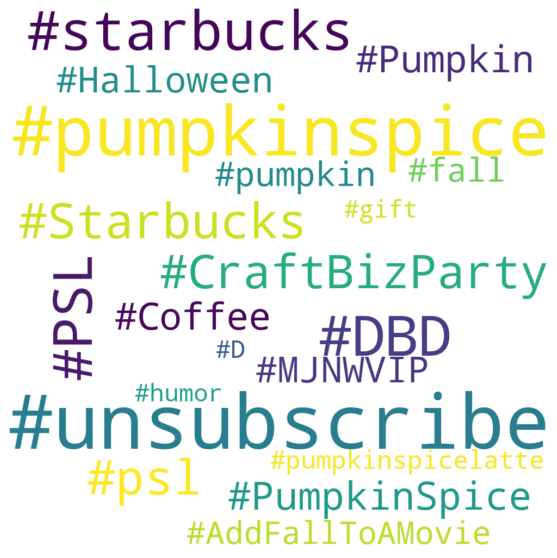

In [36]:
hashtag_ordered_dict = {}
for item in hashtag_ordered_list[0:20]:
    hashtag_ordered_dict[item[0]] = item[1]
    
wordcloud = WordCloud(width=1000, height=1000, random_state=21, max_font_size=200, background_color = 'white').generate_from_frequencies(hashtag_ordered_dict)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')

plt.show()

#make wordcloud plot of the most used hashtags.
#use dictionary where the keys are words and the values are the number of appearances

In [37]:
mentions = []
mention_pattern = re.compile(r"@[a-zA-z_]+")
mention_matches = list(tweets['tweet_text'].apply(mention_pattern.findall))


In [38]:
mentions_dict = {}
for match in mention_matches:
    for singlematch in match:
        if singlematch not in mentions_dict.keys():
            mentions_dict[singlematch] = 1
        else:
            mentions_dict[singlematch] = mentions_dict[singlematch]+1
            

In [39]:
mentions_ordered_list = sorted(mentions_dict.items(), key=lambda x: x[1])
mentions_ordered_list = mentions_ordered_list[::-1]

#ordered list with most mentioned users and count of mentions

In [40]:
mentions_ordered_values = []
mentions_ordered_keys = []

for item in mentions_ordered_list[:20]:
    mentions_ordered_keys.append(item[0])
    mentions_ordered_values.append(item[1])
    
#top 20 mentioned users and values in two lists

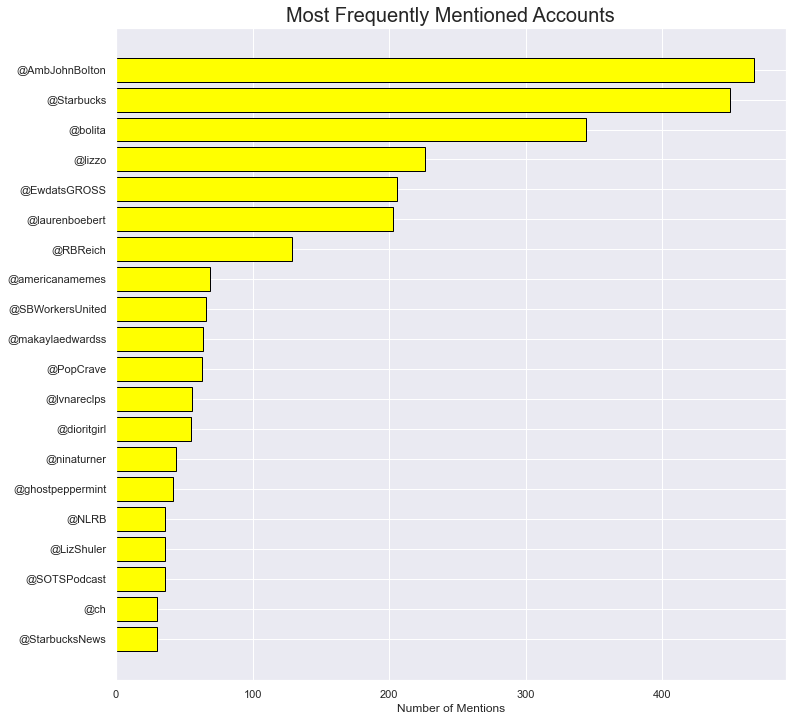

In [41]:
fig, ax = plt.subplots(figsize = (12,12))
y_pos = np.arange(len(mentions_ordered_values))
ax.barh(y_pos, list(mentions_ordered_values)[::-1], align='center', color='yellow', edgecolor='black', linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(list(mentions_ordered_keys)[::-1])
ax.set_xlabel("Number of Mentions")
ax.set_title("Most Frequently Mentioned Accounts", fontsize = 20)

plt.show()

#graph of most mentioned accounts

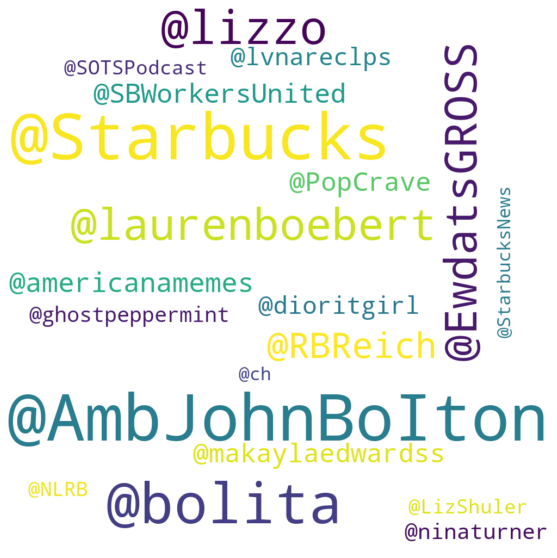

In [42]:
#mentions wordcloud just like replies word cloud

mentions_ordered_dict = {}
for item in mentions_ordered_list[:20]:
    mentions_ordered_dict[item[0]] = item[1]
    
wordcloud = WordCloud(width=1000,height=1000, random_state=21, max_font_size=200,background_color='white').generate_from_frequencies(mentions_ordered_dict)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

In [43]:
# Tweet sentiment Analysis

train, test = model_selection.train_test_split(tweets, test_size=0.3, train_size=0.7, random_state=10)

In [44]:
len(train)

6398

In [45]:
len(test)

2743

In [46]:
# Get stop words to omit from analysis
from nltk.corpus import stopwords
stopword = stopwords.words('english')
# adding some irrelevant words to our stopwords after running the tokenizer below.
extended_stop = ['https', 'stud_status', '//t.co/7pw885i0zw', 'ashnikko', 'lvnareclps', "n't", 'digitalprex', '//t.co/qthygenygi',
                 'ik', 'een', 'heb', 'ca', 'teresamaly', 'bigtoofedblonde', 'ikuflyinn', 'mi', 'llego', 'en', 'kaars', 'botten',
                 'kaarsen', 'fuck', 'fuc', 'bitch']
stopword.extend(extended_stop)

In [47]:
# Define tokenization function

def common_word_getter(row):
    words = row.tweet_text.lower()
    words = nltk.word_tokenize(words)
    frequency = nltk.FreqDist(words)
    frequency = [(w, f) for (w, f) in frequency.items() if w.lower() not in stopword]
    frequency = [(w, f) for (w, f) in frequency if len(w) > 1]
    frequency.sort(key=lambda tup: tup[1], reverse=True)
    most_common = frequency[:5]
    return most_common

In [48]:
common_list = []

for index, row in train.iterrows():
    common_list.extend([i[0] for i in common_word_getter(row)])

In [49]:
common_list[:50]

['rt',
 'ewdatsgross',
 'psa',
 'food',
 'pyramid',
 'pumpkin',
 'spice',
 'bsck',
 'stsrbucks',
 'sppoky',
 'rt',
 'ambjohnboiton',
 'pumpkin',
 'spice',
 'lattes',
 '//t.co/avpxoz1vng',
 'news',
 'wordsv',
 'menace',
 'society',
 'rt',
 'alexn_dra',
 'one',
 'thing',
 'hate',
 'rt',
 'squidgame',
 'squad',
 'starbucks',
 'ready',
 'rt',
 'ewdatsgross',
 'psa',
 'food',
 'pyramid',
 'dominos',
 'aoc',
 'jlo',
 'could',
 'edit',
 'rt',
 'ambjohnboiton',
 'pumpkin',
 'spice',
 'lattes',
 'protein',
 'orgain',
 'organic',
 'plant',
 'based']

In [50]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances

In [51]:
vect = CountVectorizer(stop_words=stopword, max_features=10)

In [52]:
train_vectors = vect.fit_transform(train.tweet_text)
train_vectors

/opt/homebrew/Cellar/jupyterlab/3.4.5/libexec/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['7pw885i0zw', 'co', 'qthygenygi'] not in stop_words.
  warnings.warn(


<6398x10 sparse matrix of type '<class 'numpy.int64'>'
	with 22977 stored elements in Compressed Sparse Row format>

In [53]:
vect.get_feature_names_out()

array(['back', 'co', 'fall', 'latte', 'lattes', 'pumpkin', 'rt', 'season',
       'spice', 'starbucks'], dtype=object)

In [54]:
test_vectors = vect.transform(test.tweet_text)
test_vectors

<2743x10 sparse matrix of type '<class 'numpy.int64'>'
	with 9912 stored elements in Compressed Sparse Row format>

In [55]:
average_vector = train_vectors.mean(axis=0)
average_vector

matrix([[0.14723351, 0.34510785, 0.0812754 , 0.29946858, 0.11159737,
         1.05720538, 0.44295092, 0.11863082, 0.98046264, 0.18599562]])

In [56]:
scores = cosine_distances(X=average_vector, Y=test_vectors)
scores

/opt/homebrew/Cellar/jupyterlab/3.4.5/libexec/lib/python3.10/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


array([[0.10181389, 0.15885402, 0.19934876, ..., 0.12875545, 0.11925928,
        0.10181389]])

In [57]:
from wordcloud import WordCloud, STOPWORDS
print(type(STOPWORDS))
STOPWORDS.update(extended_stop)

<class 'set'>


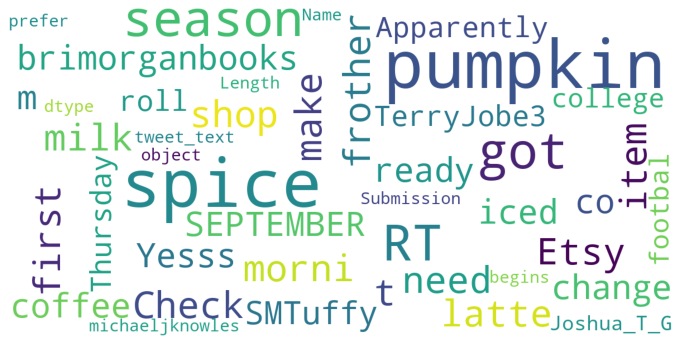

In [58]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=STOPWORDS,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(tweets['tweet_text'])

In [59]:
import re

def remove_stopwords_from_tweets(tweet):
    updated_tweet = tweet
    updated_tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",tweet).split())
    updated_tweet = " ".join(word for word in updated_tweet.split() if word not in (stopword))
    return updated_tweet

In [60]:
tweets['updated_tweet'] = tweets['tweet_text'].apply(lambda x: remove_stopwords_from_tweets(x.lower()))
tweets.head()

,tweet_id,author_id,tweet_text,like_count,quote_count,reply_count,retweet_count,place,date,RT,Reply,updated_tweet
0,1563558331608100864,967075191842099200,Check out this item in my Etsy shop https://t....,0,0,0,0,,2022-08-27,False,False,check item etsy shop
1,1563558255502053376,1269673234552758276,i need to get a milk frother so i can make my ...,0,0,0,0,None,2022-08-27,False,False,need get milk frother make pumpkin spice cold ...
2,1563558116423188480,94892479,Having my first pumpkin spice latte this morni...,0,0,0,0,None,2022-08-27,False,False,first pumpkin spice latte morning
3,1563558033669509122,1096866679013982210,@brimorganbooks Yesss! We got pumpkin spice co...,0,0,0,0,None,2022-08-27,False,True,yesss got pumpkin spice cookies grocery
4,1563557995677569024,746878617397899264,Got my pumpkin spice iced coffee I’m ready to ...,0,0,0,0,None,2022-08-27,False,False,got pumpkin spice iced coffee ready start day


In [61]:
from textblob import TextBlob

tweets['polarity'] = tweets['updated_tweet'].apply(lambda x: TextBlob(x).sentiment[0])
tweets.loc[tweets['polarity'] < 0]

,tweet_id,author_id,tweet_text,like_count,quote_count,reply_count,retweet_count,place,date,RT,Reply,updated_tweet,polarity
1,1563558255502053376,1269673234552758276,i need to get a milk frother so i can make my ...,0,0,0,0,None,2022-08-27,False,False,need get milk frother make pumpkin spice cold ...,-0.600000
9,1563557669755326464,8771022,@IsraelG18676630 You’re in! We’ll make sure yo...,0,0,0,0,None,2022-08-27,False,True,make sure miss 3 medium pumpkin cream cold bre...,-0.050000
14,1563557149330251777,1548518234504273922,Pumpkin Spice makes my nipples hard! \n\n#sexy...,1,0,0,0,None,2022-08-27,False,False,pumpkin spice makes nipples hard sexysaturday ...,-0.291667
17,1563557042299645953,79327509,I have no money but pumpkin spice cold brew is...,0,0,0,0,None,2022-08-27,False,False,money pumpkin spice cold brew back,-0.300000
22,1563556599553110020,861336442542276609,RT @stanzipotenza: Now that we’re entering fal...,0,0,0,157,None,2022-08-27,True,False,rt entering fall territory one cares anti pump...,-0.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9098,1565432852577230848,131478620,@venusianplasma Loose Mongoose Cafe has Pumpki...,0,0,0,0,,2022-09-01,False,True,loose mongoose cafe pumpkin spice options well,-0.076923
9102,1565432803340259330,971793528488591362,"Also, I know I usually do a long thread of max...",0,0,0,0,None,2022-09-01,False,False,also know usually long thread max risking ever...,-0.150000
9122,1565432444643328002,18659187,RT @LizShuler: OMG! Starbucks’ pumpkin spice l...,0,0,0,287,,2022-09-01,True,False,rt omg starbucks pumpkin spice latte returned ...,-0.500000
9133,1565432230712709120,1411425702805610496,RT @SOTSPodcast: Pumpkin Spice lattes and Pier...,0,0,0,733,None,2022-09-01,True,False,rt pumpkin spice lattes pierce veil back big w...,-0.266667


In [62]:
# our negative sentiment doesn't appear totally accurate...
tweets.loc[tweets['polarity'] == 0]

,tweet_id,author_id,tweet_text,like_count,quote_count,reply_count,retweet_count,place,date,RT,Reply,updated_tweet,polarity
0,1563558331608100864,967075191842099200,Check out this item in my Etsy shop https://t....,0,0,0,0,,2022-08-27,False,False,check item etsy shop,0.0
3,1563558033669509122,1096866679013982210,@brimorganbooks Yesss! We got pumpkin spice co...,0,0,0,0,None,2022-08-27,False,True,yesss got pumpkin spice cookies grocery,0.0
6,1563557799228948480,94270683,i’ve acquired a pumpkin spice https://t.co/HE7...,2,0,1,0,None,2022-08-27,False,False,acquired pumpkin spice,0.0
8,1563557674394210304,1472635069403594752,@BigToofedBlonde Was a whiff of pumpkin spice?...,0,0,0,0,None,2022-08-27,False,True,whiff pumpkin spice,0.0
10,1563557473604096009,873287203928944640,@Starbucks so when can I get my Pumpkin Spice ...,0,0,0,0,,2022-08-27,False,True,get pumpkin spice latte,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9130,1565432339622248458,2970619900,It’s Sept 1 so won’t you join me in breaking o...,7,0,1,0,None,2022-09-01,False,False,sept 1 join breaking pumpkin spice note request,0.0
9134,1565432224605954049,1484585508504281091,RT @DragonFindom: Pumpkin Spice Lattes are bac...,0,0,0,34,None,2022-09-01,True,False,rt pumpkin spice lattes back manifesting sub c...,0.0
9135,1565432211041828864,3128613944,RT @americanamemes: People in LA when it’s Pum...,0,0,0,836,None,2022-09-01,True,False,rt people la pumpkin spice latte season gonna ...,0.0
9138,1565432201432416259,252803959,"RT @TerryJobe3: It's Thursday, college footbal...",0,0,0,1,None,2022-09-01,True,False,rt thursday college football labor day weekend...,0.0


In [63]:
tweets['sentiment'] = tweets['polarity'].apply(lambda x: 'positive' if x > 0 else('negative' if x<0 else 'neutral'))
tweets.head()

,tweet_id,author_id,tweet_text,like_count,quote_count,reply_count,retweet_count,place,date,RT,Reply,updated_tweet,polarity,sentiment
0,1563558331608100864,967075191842099200,Check out this item in my Etsy shop https://t....,0,0,0,0,,2022-08-27,False,False,check item etsy shop,0.00,neutral
1,1563558255502053376,1269673234552758276,i need to get a milk frother so i can make my ...,0,0,0,0,None,2022-08-27,False,False,need get milk frother make pumpkin spice cold ...,-0.60,negative
2,1563558116423188480,94892479,Having my first pumpkin spice latte this morni...,0,0,0,0,None,2022-08-27,False,False,first pumpkin spice latte morning,0.25,positive
3,1563558033669509122,1096866679013982210,@brimorganbooks Yesss! We got pumpkin spice co...,0,0,0,0,None,2022-08-27,False,True,yesss got pumpkin spice cookies grocery,0.00,neutral
4,1563557995677569024,746878617397899264,Got my pumpkin spice iced coffee I’m ready to ...,0,0,0,0,None,2022-08-27,False,False,got pumpkin spice iced coffee ready start day,0.20,positive


In [64]:
tweet_sentiment = tweets.groupby(tweets['sentiment'])

In [65]:
tweets.loc[tweets['sentiment']=='neutral']

,tweet_id,author_id,tweet_text,like_count,quote_count,reply_count,retweet_count,place,date,RT,Reply,updated_tweet,polarity,sentiment
0,1563558331608100864,967075191842099200,Check out this item in my Etsy shop https://t....,0,0,0,0,,2022-08-27,False,False,check item etsy shop,0.0,neutral
3,1563558033669509122,1096866679013982210,@brimorganbooks Yesss! We got pumpkin spice co...,0,0,0,0,None,2022-08-27,False,True,yesss got pumpkin spice cookies grocery,0.0,neutral
6,1563557799228948480,94270683,i’ve acquired a pumpkin spice https://t.co/HE7...,2,0,1,0,None,2022-08-27,False,False,acquired pumpkin spice,0.0,neutral
8,1563557674394210304,1472635069403594752,@BigToofedBlonde Was a whiff of pumpkin spice?...,0,0,0,0,None,2022-08-27,False,True,whiff pumpkin spice,0.0,neutral
10,1563557473604096009,873287203928944640,@Starbucks so when can I get my Pumpkin Spice ...,0,0,0,0,,2022-08-27,False,True,get pumpkin spice latte,0.0,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9130,1565432339622248458,2970619900,It’s Sept 1 so won’t you join me in breaking o...,7,0,1,0,None,2022-09-01,False,False,sept 1 join breaking pumpkin spice note request,0.0,neutral
9134,1565432224605954049,1484585508504281091,RT @DragonFindom: Pumpkin Spice Lattes are bac...,0,0,0,34,None,2022-09-01,True,False,rt pumpkin spice lattes back manifesting sub c...,0.0,neutral
9135,1565432211041828864,3128613944,RT @americanamemes: People in LA when it’s Pum...,0,0,0,836,None,2022-09-01,True,False,rt people la pumpkin spice latte season gonna ...,0.0,neutral
9138,1565432201432416259,252803959,"RT @TerryJobe3: It's Thursday, college footbal...",0,0,0,1,None,2022-09-01,True,False,rt thursday college football labor day weekend...,0.0,neutral


In [66]:
tweet_sentiment.size()

sentiment
negative    1226
neutral     4910
positive    3005
dtype: int64

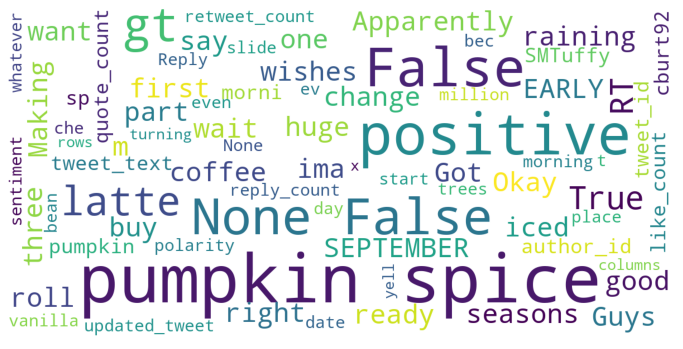

In [67]:
# positive sentiment word cloud

show_wordcloud(tweets.loc[tweets['sentiment'] == 'positive'])

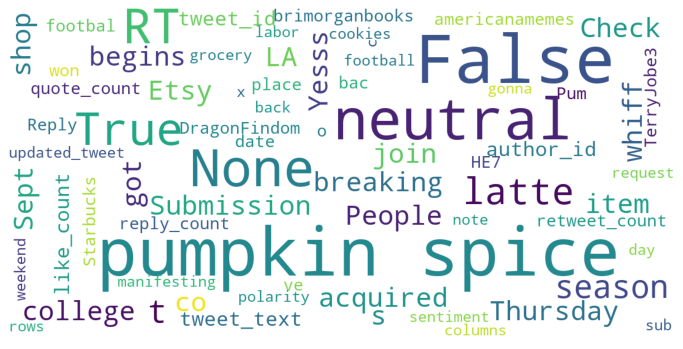

In [68]:
# neutral sentiment word cloud

show_wordcloud(tweets.loc[tweets['sentiment'] == 'neutral'])

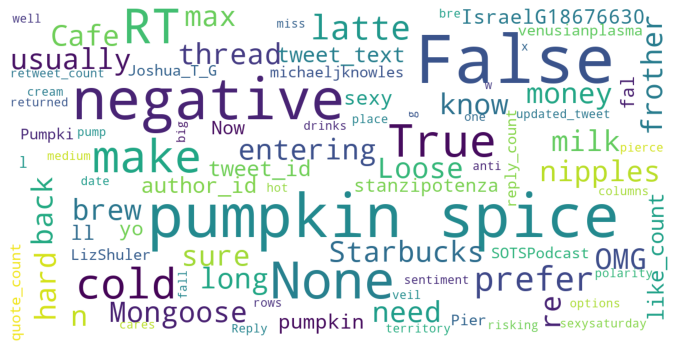

In [69]:
# negative sentiment word cloud

show_wordcloud(tweets.loc[tweets['sentiment'] == 'negative'])

In [70]:
tweets.loc[tweets['tweet_text'].str.contains("starbucks")].describe()

,like_count,quote_count,reply_count,retweet_count,polarity
count,246.000000,246.000000,246.000000,246.000000,246.000000
mean,0.317073,0.008130,0.081301,61.987805,0.078491
std,1.991070,0.127515,0.273854,120.743800,0.234340
min,0.000000,0.000000,0.000000,0.000000,-0.800000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,54.250000,0.112321
max,30.000000,2.000000,1.000000,487.000000,1.000000
